In [1]:
# import required libraries
import warnings
warnings.filterwarnings("ignore")

In [2]:
%load_ext tensorboard

In [6]:
import re
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import tensorflow as tf 
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split

In [5]:
data_dir = "./train_val/"

In [6]:
# get to know whats inside the data
os.listdir(data_dir)

['train', 'val']

In [7]:
# initialize image sizes and parameters
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 32

In [8]:
os.listdir(data_dir + "train")

['healthy_wheat', 'leaf_rust', 'stem_rust']

# process the data with tf.data 


In [9]:
# a function to show the image batch
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [10]:
# get the number of images
train_image_count = len(list(Path(data_dir + "train").glob('*/*')))
val_image_count = len(list(Path(data_dir + "val").glob('*/*')))
print(train_image_count)
val_image_count

699


177

In [11]:
# train data
train_list_ds = tf.data.Dataset.list_files(str(data_dir + "train/" +'*/*'))
# validation data
val_list_ds = tf.data.Dataset.list_files(str(data_dir + "val/" +'*/*'))

In [12]:
# images class names
CLASS_NAMES = np.array([item.name for item in Path(data_dir + "train").glob('*')])
CLASS_NAMES

array(['healthy_wheat', 'leaf_rust', 'stem_rust'], dtype='<U13')

In [13]:
for f in train_list_ds.take(5):
  print(f.numpy())

b'.\\train_val\\train\\leaf_rust\\6V9W4D.jfif'
b'.\\train_val\\train\\stem_rust\\XONN0P.jpg'
b'.\\train_val\\train\\stem_rust\\2BMZSY.jpg'
b'.\\train_val\\train\\leaf_rust\\YWGB88.jfif'
b'.\\train_val\\train\\healthy_wheat\\CHJDTJ.jfif'


In [14]:
# read image 
# a function to read data
def read_image(img_path):
    img_loader = tf.io.read_file(img_path)
    img_decoder = tf.image.decode_jpeg(img_loader, channels=CHANNELS)
    img = tf.image.convert_image_dtype(img_decoder, tf.float32)
    img = tf.image.resize(img, [WIDTH, HEIGHT])
    return img

In [15]:
# To get labels
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [16]:
# process paths
def process_path(file_path):
    label = get_label(file_path)
    img = read_image(file_path)
    return img, label

In [1]:
# using tensorflow dataset.map to create a dataset of image, label pairs
train_labeled_ds = train_list_ds.map(process_path, num_parallel_calls=-1)
val_labeled_ds = val_list_ds.map(process_path, num_parallel_calls=-1)

NameError: name 'train_list_ds' is not defined

In [18]:
for image, label in train_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  False


In [19]:
# prepare data for training 
def prepare_for_training(ds, shuffle_buffer_size=100, training=True):
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  if training:
    ds = ds.repeat()
    print("repeating")
  else:
    pass
  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=-1)

  return ds

In [22]:
train_ds = prepare_for_training(train_labeled_ds)
val_ds = prepare_for_training(val_labeled_ds, training=False)
image_batch, label_batch = next(iter(train_ds))

repeating


IndexError: index 0 is out of bounds for axis 0 with size 0

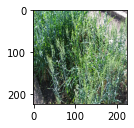

In [23]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [24]:
# prepare the test data
test_list = "./test/"

In [2]:
test_list_ds = tf.data.Dataset.list_files(str(test_list +'*/*'))

NameError: name 'tf' is not defined

In [26]:
# test list file names
for f in test_list_ds.take(5):
  print(f.numpy())

b'.\\test\\test\\EF1VE8.JPG'
b'.\\test\\test\\LQLMT6.JPG'
b'.\\test\\test\\EK02MQ.JPG'
b'.\\test\\test\\TDZOK8.jpg'
b'.\\test\\test\\I83ILL.JPG'


In [27]:
# process test
def process_test(image_path):
    img = read_image(image_path)
    return img, image_path

In [28]:
test_ds = test_list_ds.map(process_test, num_parallel_calls=-1)

(224, 224, 3)
b'.\\test\\test\\EF1VE8.JPG'


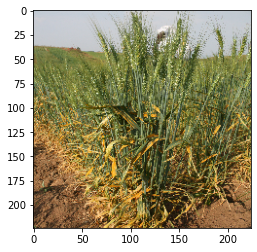

In [29]:
for i, j in test_ds.take(1):
    print(i.numpy().shape)
    print(j.numpy())
    plt.imshow(i.numpy())

# create callbacks

In [30]:
# temsorboard
log_dir="logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# model checkpoints
checkpoint_path =  "model/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "/cp.ckpt"
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_categorical_accuracy',
            mode='max')

In [31]:
callbacks = [tensorboard, es, model_checkpoints]

In [32]:
# define class weights
leaf_rust_count = 859
stem_rust_count = 900
healthy_wheat_count = 339
total = leaf_rust_count + stem_rust_count + healthy_wheat_count

leaf_rust_weight = (1/leaf_rust_count) * (total) / 3.0
stem_rust_weight = (1/stem_rust_count) * (total) / 3.0
healthy_wheat_weight = (1/healthy_wheat_count) * (total) / 3.0

class_weight = {0:leaf_rust_weight, 1:stem_rust_weight, 2:healthy_wheat_weight}
print(class_weight)

{0: 0.8141249514939853, 1: 0.777037037037037, 2: 2.062930186823992}


#  create a simple model

In [33]:
def simple_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(224, 224, 3)))
    model.add(tf.keras.layers.MaxPool2D(2,2, padding="same"))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(256, activation="softmax"))
    model.add(tf.keras.layers.Dense(3, activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
                    loss=tf.keras.losses.categorical_crossentropy, 
                    metrics = [tf.keras.metrics.categorical_accuracy])
    return model 

In [34]:
steps_per_epoch = train_image_count // BATCH_SIZE
validation_steps = val_image_count // BATCH_SIZE
print(steps_per_epoch)
validation_steps

21


5

In [36]:
# fit the model
model = simple_model()

In [62]:
model.fit(train_ds, epochs=100, steps_per_epoch=steps_per_epoch, 
                validation_data=val_ds, validation_steps=validation_steps,
                callbacks=callbacks, class_weight=class_weight)

Train for 65 steps, validate for 5 steps
Epoch 1/100
65/65 [==============================] - 28s 426ms/step - loss: 1.0339 - categorical_accuracy: 0.4284 - val_loss: 1.0033 - val_categorical_accuracy: 0.4563
Epoch 2/100
65/65 [==============================] - 26s 399ms/step - loss: 1.0254 - categorical_accuracy: 0.4192 - val_loss: 1.0203 - val_categorical_accuracy: 0.4750
Epoch 3/100
65/65 [==============================] - 26s 396ms/step - loss: 1.0114 - categorical_accuracy: 0.4894 - val_loss: 0.9885 - val_categorical_accuracy: 0.5750
Epoch 4/100
65/65 [==============================] - 27s 415ms/step - loss: 1.0043 - categorical_accuracy: 0.4827 - val_loss: 0.9666 - val_categorical_accuracy: 0.5625
Epoch 5/100
65/65 [==============================] - 24s 376ms/step - loss: 0.9623 - categorical_accuracy: 0.5149 - val_loss: 0.9154 - val_categorical_accuracy: 0.5500
Epoch 6/100
65/65 [==============================] - 25s 389ms/step - loss: 0.9353 - categorical_accuracy: 0.5221 - val

In [35]:
# create a deeper layer
def deeper_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (5,5), activation="relu", input_shape=(224, 224, 3),
                                    kernel_initializer="he_uniform"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(2,2, padding="same"))

    model.add(tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_uniform"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(2,2, padding="same"))

    # model.add(tf.keras.layers.Dense(256, activation="relu"))

    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(3, activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
                    loss=tf.keras.losses.categorical_crossentropy, 
                    metrics = [tf.keras.metrics.categorical_accuracy])
    return model 

In [36]:
deeper_model = deeper_model()

In [37]:
deeper_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 220, 220, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 108, 108, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

In [44]:
deeper_model.fit(train_ds, epochs=100, steps_per_epoch=steps_per_epoch, 
                validation_data=val_ds, validation_steps=validation_steps,
                callbacks=callbacks)

Train for 65 steps, validate for 5 steps
Epoch 1/100
65/65 [==============================] - 29s 451ms/step - loss: 0.8971 - categorical_accuracy: 0.5591 - val_loss: 1.3627 - val_categorical_accuracy: 0.4750
Epoch 2/100
65/65 [==============================] - 27s 412ms/step - loss: 0.8523 - categorical_accuracy: 0.6010 - val_loss: 1.2172 - val_categorical_accuracy: 0.4125
Epoch 3/100
65/65 [==============================] - 26s 403ms/step - loss: 0.8295 - categorical_accuracy: 0.5942 - val_loss: 1.1254 - val_categorical_accuracy: 0.4688
Epoch 4/100
65/65 [==============================] - 26s 394ms/step - loss: 0.8096 - categorical_accuracy: 0.6149 - val_loss: 1.3211 - val_categorical_accuracy: 0.4437
Epoch 5/100
65/65 [==============================] - 25s 380ms/step - loss: 0.7907 - categorical_accuracy: 0.6245 - val_loss: 1.2405 - val_categorical_accuracy: 0.4250
Epoch 6/100
65/65 [==============================] - 26s 394ms/step - loss: 0.7839 - categorical_accuracy: 0.6394 - val

# Transfer Learning

In [9]:
IMG_SHAPE = (HEIGHT, WIDTH, CHANNELS)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [39]:
base_model.trainable = False

In [40]:
pretrained_model = tf.keras.Sequential([
base_model,
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(3, activation="softmax")
])

pretrained_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
            loss=tf.keras.losses.categorical_crossentropy, 
            metrics = [tf.keras.metrics.categorical_accuracy])

In [41]:
pretrained_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [42]:
len(pretrained_model.trainable_variables)

2

In [43]:
logdir = os.path.join('cnn_selu_callbacks')

In [44]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, profile_batch = 100000000)]

In [50]:
pretrained_model.fit(train_ds, epochs=5, steps_per_epoch=steps_per_epoch, 
                validation_data=val_ds, validation_steps=validation_steps,
                callbacks=callbacks)

Epoch 1/5
21/21 [==============================] - 217s 10s/step - loss: 0.0000e+00 - categorical_accuracy: 0.2857 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0750
Epoch 2/5
21/21 [==============================] - 219s 10s/step - loss: 0.0000e+00 - categorical_accuracy: 0.2679 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0750
Epoch 3/5
21/21 [==============================] - 254s 12s/step - loss: 0.0000e+00 - categorical_accuracy: 0.2426 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0750
Epoch 4/5
21/21 [==============================] - 246s 12s/step - loss: 0.0000e+00 - categorical_accuracy: 0.2708 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0750
Epoch 5/5
21/21 [==============================] - 224s 11s/step - loss: 0.0000e+00 - categorical_accuracy: 0.2381 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0750


In [45]:
# fine tune the model
base_model.trainable = True

In [46]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [47]:
pretrained_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
            loss=tf.keras.losses.categorical_crossentropy, 
            metrics = [tf.keras.metrics.categorical_accuracy])

In [48]:
pretrained_model.fit(train_ds, epochs=2, steps_per_epoch=steps_per_epoch, 
                validation_data=val_ds, validation_steps=validation_steps,
                callbacks=callbacks)

Epoch 1/2
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 9/21 [===========>..................] - ETA: 3:46 - loss: 0.0000e+00 - categorical_accuracy: 0.2431

KeyboardInterrupt: 

In [49]:
# resnet model
pretrained_resnet = tf.keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False,
                                                            input_shape=(HEIGHT, WIDTH, CHANNELS))

c:\users\skihiu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [50]:
pretrained_resnet.trainable = False

In [51]:
resnet = tf.keras.Sequential([
    pretrained_resnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [52]:
resnet.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
            loss=tf.keras.losses.categorical_crossentropy, 
            metrics = [tf.keras.metrics.categorical_accuracy])

In [53]:
resnet.fit(train_ds, epochs=2, steps_per_epoch=steps_per_epoch, 
                validation_data=val_ds, validation_steps=validation_steps,
                callbacks=callbacks)

Epoch 1/2
 2/21 [=>............................] - ETA: 8:07 - loss: 0.0000e+00 - categorical_accuracy: 0.3281 

KeyboardInterrupt: 

In [54]:
pretrained_resnet.trainable = True

In [55]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_resnet.layers[:fine_tune_at]:
  layer.trainable =  False

In [56]:
resnet.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
            loss=tf.keras.losses.categorical_crossentropy, 
            metrics = [tf.keras.metrics.categorical_accuracy])

In [57]:
resnet.fit(train_ds, epochs=20, steps_per_epoch=steps_per_epoch, 
                validation_data=val_ds, validation_steps=validation_steps,
                callbacks=callbacks)

Epoch 1/20


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x00000200377EF620>
Traceback (most recent call last):
  File "c:\users\skihiu\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 526, in __del__
    with ops.device(self._device):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [10]:
import tensorflow as tf
tf.__version__

'2.0.0-beta1'

# Make prediction for the test dataset

In [58]:
# test count
test_count = len(list(Path(data_dir + "test").glob('*')))
test_count

0

In [59]:
names = []
preds = []

In [60]:
for i, j in tqdm(test_ds):
    i = i.numpy()[np.newaxis, :] # add a new dimension
    prediction = model.predict_proba(i) # make predictions
    preds.append(prediction) 
    
    # use regular expressions to extract the name of image
    name = j.numpy()
    name = re.sub("[^A-Z0-9]", "", str(name))
    name = name.replace("JPG", "")
    name = name.replace("PNG", "")
    name = name.replace("JPEG", "")
    name = name.replace("JFIF", "")
    names.append(name)
    # break

0it [00:00, ?it/s]


NameError: name 'model' is not defined

# Create a submission file

In [61]:
# create a dummy dataset
leaf_rust = pd.Series(range(610), name="leaf_rust", dtype=np.float32)
stem_rust = pd.Series(range(610), name="stem_rust", dtype=np.float32)
healthy_wheat = pd.Series(range(610), name="healthy_wheat", dtype=np.float32)

In [62]:
sub = pd.concat([leaf_rust, stem_rust, healthy_wheat], axis=1)

In [63]:
sub.shape

(610, 3)

In [64]:
# append real predictions to the dataset
for i in tqdm(range(0 ,len(preds))):
    sub.loc[i] = preds[i]
    # break

0it [00:00, ?it/s]


In [65]:
sub.head()

,leaf_rust,stem_rust,healthy_wheat
0,0.0,0.0,0.0
1,1.0,1.0,1.0
2,2.0,2.0,2.0
3,3.0,3.0,3.0
4,4.0,4.0,4.0


In [66]:
sub["ID"] = names

ValueError: Length of values does not match length of index

In [67]:
sub.tail()

,leaf_rust,stem_rust,healthy_wheat
605,605.0,605.0,605.0
606,606.0,606.0,606.0
607,607.0,607.0,607.0
608,608.0,608.0,608.0
609,609.0,609.0,609.0


In [68]:
cols = sub.columns.tolist()

In [69]:
 cols = cols[-1:] + cols[:-1]
 sub = sub[cols]

In [70]:
sub.head()

,healthy_wheat,leaf_rust,stem_rust
0,0.0,0.0,0.0
1,1.0,1.0,1.0
2,2.0,2.0,2.0
3,3.0,3.0,3.0
4,4.0,4.0,4.0


In [71]:
# write to csv
sub.to_csv("submission/simple_model_augmented_epochs.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'submission/simple_model_augmented_epochs.csv'